# Movies Recommender System
本notebook將對MovieLens資料集進行資料探索，並實作三種不同類型推薦演算法
* 簡單熱門推薦法
* 基於內容推薦(Content-based Recommendation)
* 協同過濾(User-based Collaborative Filtering)

## 匯入套件 & 讀取資料

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

movies = pd.read_csv(r"dataset\MovieLens\movies.csv")
rating = pd.read_csv(r"dataset\MovieLens\ratings.csv")
print("=====movies=====")
print(movies.head())
print("\n=====rating=====")
print(rating.head())

=====movies=====
   movieId                               title                                       genres
0        1                    Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2                      Jumanji (1995)                   Adventure|Children|Fantasy
2        3             Grumpier Old Men (1995)                               Comedy|Romance
3        4            Waiting to Exhale (1995)                         Comedy|Drama|Romance
4        5  Father of the Bride Part II (1995)                                       Comedy

=====rating=====
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


## 簡單熱門推薦法

簡單熱門推薦法是基於電影受歡迎的程度來決定要推薦哪部電影，這種所謂符合『大眾口味』的電影通常能得到大多數人的青睞，但是卻沒有辦法照顧到非主流的客群，不過對於一個新客戶而言，在無法得知該客戶的喜好之前，仍然是一個簡單且有效的推薦方法。

資料集中rating表示該使用者對該電影的評價，分數範圍是[1,5]之間。我們可以簡單的以電影分組進行分數的平均，但這並非十分公平，因為有可能一部電影只有少數人觀看，一部電影被1000人打出平均4.5的分數，顯然會比3人打出平均4.8的分數還要來得有說服力。因此熱門程度的公式必須涵蓋**投票人數**及**平均得分**。我們採取IMDB上對電影分數的計算方式。

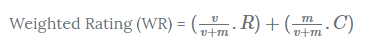

* v 是該部電影投票人數
* m 是清單上的最小投票數
* R 是該部電影平均分數
* C 是全部電影的平均分數

In [2]:
vote_count = rating.groupby("movieId").count()["userId"].rename("vote_count").reset_index()
vote_average = rating.groupby("movieId").mean()["rating"]
C = vote_average.mean()

print("=====vote count=====")
print(vote_count.head())
print("\n=====vote average=====")
print(vote_average.head())
print("\n")
print(f"全部電影的平均分數: {C:.2f}")

=====vote count=====
   movieId  vote_count
0        1         215
1        2         110
2        3          52
3        4           7
4        5          49

=====vote average=====
movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: rating, dtype: float64


全部電影的平均分數: 3.26


上面我們得到全部電影的平均分數C是3.26，接著我們要決定合適的清單上的最小投票數m，來過濾掉投票數太低的電影，我們採取第90百分位數。

In [3]:
m = vote_count["vote_count"].quantile(0.9)
q_movies = vote_count[vote_count["vote_count"]>=m].reset_index(drop=True)
q_movies["vote_average"] = vote_average[q_movies.movieId].values

print(f"m: {int(m)}\n")
print(q_movies.head())

m: 27

   movieId  vote_count  vote_average
0        1         215      3.920930
1        2         110      3.431818
2        3          52      3.259615
3        5          49      3.071429
4        6         102      3.946078


得到最小投票數m為27，並且過濾掉投票數低於27的電影，接著我們套入到上述介紹IMDB的公式，來計算分數，並且用bar圖來呈現最熱門的幾部電影。

Text(0.5, 1.0, 'Popular Movies')

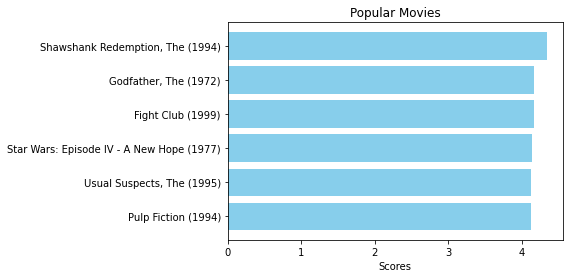

In [4]:
def weighted_rating(x, m=m, C=C):
    v = x["vote_count"]
    R = x["vote_average"]
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies["score"] = q_movies.apply(weighted_rating,axis=1).values
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

df = pd.merge(q_movies, movies, on='movieId')
df.head()

plt.barh(df['title'].head(6),df['score'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Scores")
plt.title("Popular Movies")

要注意的是，上面的推薦電影清單單純是按照熱門程度來檢視，完全不考慮其他資訊，我們可以檢視不同類型最熱門的幾部電影，來做更細緻的推薦。

In [5]:
genres = df.genres.str.get_dummies(sep="|")
df = pd.merge(df,genres,left_index=True,right_index=True)
df.drop("genres",axis=1,inplace=True)

# Top Action Movies
columns = ["title","vote_count","vote_average","score"]
print("=====Top Action Movies=====")
print(df.loc[df["Action"]==1,columns].head())
# Top Comedy Movies
print("\n=====Top Comedy Movies=====")
print(df.loc[df["Comedy"]==1,columns].head())

=====Top Action Movies=====
                                                title  vote_count  vote_average     score
2                                   Fight Club (1999)         218      4.272936  4.161576
3           Star Wars: Episode IV - A New Hope (1977)         251      4.231076  4.137000
7                                  Matrix, The (1999)         278      4.192446  4.110118
8   Star Wars: Episode V - The Empire Strikes Back...         211      4.215640  4.107505
10  Raiders of the Lost Ark (Indiana Jones and the...         200      4.207500  4.095093

=====Top Comedy Movies=====
                                                title  vote_count  vote_average     score
5                                 Pulp Fiction (1994)         307      4.197068  4.121515
9                                 Forrest Gump (1994)         329      4.164134  4.095747
14                         Princess Bride, The (1987)         142      4.232394  4.077433
18  Dr. Strangelove or: How I Learned to St

## 基於內容推薦(Content-based Recommendation)
基於內容推薦(Content-based Recommendations, CB)是將使用者與電影嵌入在同一個向量空間，按照使用者和電影的相似度，為使用者推薦相似度高的影片。詳細的介紹可以參考[以Python打造簡單實用的電影推薦系統(Content-based Recommendation)](https://medium.com/qiubingcheng/%E5%8D%8A%E5%B0%8F%E6%99%82%E6%89%93%E9%80%A0%E7%B0%A1%E5%96%AE%E5%AF%A6%E7%94%A8%E7%9A%84%E9%9B%BB%E5%BD%B1%E6%8E%A8%E8%96%A6%E7%B3%BB%E7%B5%B1-%E9%99%84%E5%AE%8C%E6%95%B4python%E7%A8%8B%E5%BC%8F%E7%A2%BC-b372769939af)。

電影的特徵就是genres這個欄位，而我們注意到此時是以|符號將多個類型串接在一起的文字，電腦只能夠處理數值，我們使用獨熱編碼(One Hot Encoder)轉成數值格式。

In [6]:
# movie vector
dummies = movies["genres"].str.get_dummies('|')
movie_vec = pd.concat([movies["movieId"], dummies], axis=1)
movie_vec.set_index("movieId",inplace=True)

print(movies["genres"].head())
print(movie_vec.iloc[:5,:10])

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object
         (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  Fantasy
movieId                                                                                                        
1                         0       0          1          1         1       1      0            0      0        1
2                         0       0          1          0         1       0      0            0      0        1
3                         0       0          0          0         0       1      0            0      0        0
4                         0       0          0          0         0       1      0            0      1        0
5                         0       0          0         

使用者的特徵就是觀看歷史的電影特徵，先將觀看紀錄跟電影類型merge在一起，同樣要使用獨熱編碼進行型態轉換，因此使用者的資料型態會跟電影一樣，如此就可以計算相似度。

In [7]:
#user vector 
movie_rating = pd.merge(rating[["userId","movieId"]], movies[["movieId","genres"]], on='movieId')
dummies = movie_rating["genres"].str.get_dummies('|')
user_vec = pd.concat([movie_rating, dummies], axis=1)
user_vec.drop(['movieId', 'genres'],axis=1,inplace=True)
user_vec = user_vec.groupby("userId").mean()

print(user_vec.iloc[:5,:10])

        (no genres listed)    Action  Adventure  Animation  Children    Comedy     Crime  Documentary     Drama   Fantasy
userId                                                                                                                   
1                      0.0  0.387931   0.366379   0.125000  0.181034  0.357759  0.193966     0.000000  0.293103  0.202586
2                      0.0  0.379310   0.103448   0.000000  0.000000  0.241379  0.344828     0.103448  0.586207  0.000000
3                      0.0  0.368421   0.289474   0.105263  0.131579  0.236842  0.052632     0.000000  0.421053  0.078947
4                      0.0  0.115741   0.134259   0.027778  0.046296  0.481481  0.125000     0.009259  0.555556  0.087963
5                      0.0  0.204545   0.181818   0.136364  0.204545  0.340909  0.272727     0.000000  0.568182  0.159091


我們建構一個相似度矩陣，讓每一個user都跟每一部電影計算相似度，後續我們直接對特定user對應的那個列(row)進行排序，便知道該user觀看歷史紀錄與哪部電影最相似。

In [8]:
user_movie_similarity_matrix = cosine_similarity(user_vec.values,movie_vec.values)
user_movie_similarity_matrix = pd.DataFrame(user_movie_similarity_matrix, index=user_vec.index,columns=movie_vec.index)

num_user,num_mov =  user_movie_similarity_matrix.shape
print(f"user_movie_similarity_matrix - #user: {num_user}, #movie: {num_mov}\n")
print(user_movie_similarity_matrix.iloc[:5,:5])

user_movie_similarity_matrix - #user: 610, #movie: 62423

movieId         1         2         3         4         5
userId                                                   
1        0.634702  0.498514  0.382473  0.507109  0.411876
2        0.167015  0.064685  0.211259  0.539039  0.261420
3        0.434861  0.333333  0.300815  0.526316  0.273482
4        0.408476  0.182058  0.622791  0.885179  0.565426
5        0.509525  0.350823  0.465475  0.745499  0.379777


In [9]:
def get_the_most_similar_movies(user_id, user_movie_matrix,num):
    """Find the top-n movies most similar to the user"""
    user_vec = user_movie_matrix.loc[user_id].values 
    sorted_index = np.argsort(user_vec)[::-1][:num]
    return list(user_movie_matrix.columns[sorted_index])

#Find the top-10 movies most similar to the user1
user = 1
movied_ids = get_the_most_similar_movies(user, user_movie_similarity_matrix,10)
print(f"user: {user}\n")
print(movies[movies["movieId"].isin(movied_ids)]["title"])

user: 1

4850                     Stunt Man, The (1980)
9315                        Unstoppable (2004)
11829                Hunting Party, The (2007)
12879                 The Wrecking Crew (1968)
13380                        Graduation (2007)
23306    Dragonheart 2: A New Beginning (2000)
25008                      The 39 Steps (1959)
31401                          Bail Out (1990)
33107                    Joseph Andrews (1977)
33940                  Once Upon a Time (2008)
Name: title, dtype: object


## 協同過濾(User-based Collaborative Filtering)
協同過濾(User-based Collaborative Filtering)是根據擁有相似經驗的群體的喜好來推薦使用者感興趣的資訊。
大抵流程如下：
* 找到與使用者擁有相同電影愛好(相似度高)的人
* 找到該相似使用者們觀看的其他電影
* 將這些相似使用者的平均電影評分最高幾部推薦給該使用者

詳細說明請參考[Python實現推薦系統的協同過濾算法(User-based Collaborative Filtering)](https://medium.com/qiubingcheng/%E4%BB%A5python%E5%AF%A6%E7%8F%BE%E6%8E%A8%E8%96%A6%E7%B3%BB%E7%B5%B1%E7%9A%84%E5%8D%94%E5%90%8C%E9%81%8E%E6%BF%BE%E7%AE%97%E6%B3%95-d35cc1a1ec8a)

首先 我們先將觀看紀錄rating與電影資料進行合併，再對genres使用獨熱編碼，得到表格如下。

In [10]:
movie_rating = pd.merge(rating[["userId","movieId","rating"]], movies[["movieId","genres"]], on='movieId')
dummies = movie_rating["genres"].str.get_dummies('|')
df = pd.concat([movie_rating, dummies], axis=1)
df.drop(['genres'],axis=1,inplace=True)

print(df.iloc[:5,:10])

   userId  movieId  rating  (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime
0       1        1     4.0                   0       0          1          1         1       1      0
1       5        1     4.0                   0       0          1          1         1       1      0
2       7        1     4.5                   0       0          1          1         1       1      0
3      15        1     2.5                   0       0          1          1         1       1      0
4      17        1     4.5                   0       0          1          1         1       1      0


接著，按照流程我們要找到該使用者最相似的使用者，就是計算彼此歷史觀看紀錄中的電影類型的相似度。
find_the_most_similar_users函式參數的**num**，是指要找到多少個相似的使用者。
我們以user1作為例子來推薦，num設定為15。

In [11]:
def find_common_movies(user1,user2):
    """Find movies that both users have watched"""
    s1 = set((df.loc[df["userId"]==user1,"movieId"].values))
    s2 = set((df.loc[df["userId"]==user2,"movieId"].values))
    return s1.intersection(s2)

def cal_similarity_for_movie_ratings(user1,user2,movies_id,method="cosine"):
    """Calculate the similarity for movie ratings between user1 and user2"""
    u1 = df[df["userId"]==user1]
    u2 = df[df["userId"]==user2]
    vec1 = u1[u1.movieId.isin(movies_id)].sort_values(by="movieId")["rating"].values
    vec2 = u2[u2.movieId.isin(movies_id)].sort_values(by="movieId")["rating"].values
    if method=="cosine":        
        return dot(vec1, vec2)/(norm(vec1)*norm(vec2))
    return None

def find_the_most_similar_users(user, num):
    # Calculate the similarity between the user and other users
    similarities = []
    user_ids = []
    for other_user in df.userId.unique():
        if other_user == user:
            continue
        
        common_movies = find_common_movies(user,other_user)
        if len(common_movies)<10:
            sim = 0
        else:
            sim = cal_similarity_for_movie_ratings(user,other_user,common_movies)
        
        similarities.append(sim)
        user_ids.append(other_user)
            
    # Find top n similar users
    similarities,user_ids = np.array(similarities),np.array(user_ids)
    sorted_index = (np.argsort(similarities)[::-1][:num]).tolist()
    most_similar_users = user_ids[sorted_index] 
    return most_similar_users

In [12]:
user = 1
num = 15
similar_users = find_the_most_similar_users(user,num)

print(f"user: {user}")
print(f"The most similar users: {similar_users}")

user: 1
The most similar users: [180 596 476 601 172  72 236 248 178 348 204 251 526 408  62]


找到最相似的user們之後，我們計算這些user觀看過的電影中，平均而言給予哪部電影最高的評分。
recommend的回傳值top_ratings，其rating欄位表示這些相似使用者對這部電影的平均分數。

In [13]:
def recommend(user,similar_users ,top_n=10):
    # Find the movies the user hasn't seen and the similar users have seen.
    seen_movies = np.unique(df.loc[df["userId"]==user,"movieId"].values)
    not_seen_cond = df["movieId"].isin(seen_movies)==False
    similar_cond = df["userId"].isin(similar_users)
    not_seen_movies_ratings = df[not_seen_cond & similar_cond][["movieId","rating"]]
    
    # Find average ratings by the most similar users
    average_ratings = not_seen_movies_ratings.groupby("movieId").mean()
    average_ratings.reset_index(inplace=True)
    top_ratings = average_ratings.sort_values(by="rating",ascending=False).iloc[:top_n]
    top_ratings.reset_index(inplace=True,drop=True)
    return top_ratings

In [14]:
top_n = 10
top_ratings = recommend(user,similar_users, top_n)
print(f"Top-{top_n} average ratings by the most simiilar users:")
print(pd.merge(top_ratings, movies[["movieId","title"]], on='movieId'))

Top-10 average ratings by the most simiilar users:
   movieId  rating                                         title
0     2683     5.0  Austin Powers: The Spy Who Shagged Me (1999)
1    53322     5.0                       Ocean's Thirteen (2007)
2   122906     5.0                          Black Panther (2017)
3     1960     5.0                      Last Emperor, The (1987)
4      588     5.0                                Aladdin (1992)
5     5630     5.0                             Red Dragon (2002)
6    44195     5.0                  Thank You for Smoking (2006)
7    90430     5.0                                Carnage (2011)
8   128360     5.0                      The Hateful Eight (2015)
9     5949     5.0                       Intact (Intacto) (2001)
